<a href="https://colab.research.google.com/github/subin1005/project/blob/main/%EA%B1%B4%EC%84%A4%EA%B8%B0%EA%B3%84_%EC%98%A4%EC%9D%BC%EC%83%81%ED%83%9C_%EB%B6%84%EB%A5%98_%5Btensorflow%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 건설기계 오일상태 분류 경진대회

### 0. 대회설명

 - **대회명** : 건설기계 오일 상태 분류 AI 경진대회
 - **대회주제** : 건설장비에서 작동오일의 상태 판단 모델개발 (정상, 이상의 이진분류)
 - **분석 아이디어** : 지식 증류(Knowledge Distillation) 기법을 통한 모델 학습

**지식 증류 (Knowledge Distillation)** : 이미 학습된 모델(교사모델)을 이용하여
학습이 부족한 모델(학생모델)을 학습시키는 방법으로 이번 분석에서 train이 가진 정보가 test의 정보보다 많아서, (= train 변수 개수 > test 변수 개수)  train의 전체 변수로 먼저 모델을 학습한 뒤에, 그 모델을 이용하여 test에 속하는 변수들만을 가지고 학습하는 방법이다.

### 1. 라이브러리 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### 2. 데이터 불러오기

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/건설기계 오일 상태 분류 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/건설기계 오일 상태 분류 경진대회/test.csv')

- 시드고정

In [ ]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2, #1e-2,
    'BATCH_SIZE':256, #256
    'SEED':41 #41
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed_all(seed)
seed_everything(CFG['SEED'])

### 3. 데이터 탐색 및 전처리

- 데이터 형태확인

In [ ]:
train.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0


In [ ]:
test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6041 non-null   object 
 1   COMPONENT_ARBITRARY  6041 non-null   object 
 2   ANONYMOUS_1          6041 non-null   int64  
 3   YEAR                 6041 non-null   int64  
 4   ANONYMOUS_2          6041 non-null   int64  
 5   AG                   6041 non-null   int64  
 6   CO                   6041 non-null   int64  
 7   CR                   6041 non-null   int64  
 8   CU                   6041 non-null   int64  
 9   FE                   6041 non-null   int64  
 10  H2O                  6041 non-null   float64
 11  MN                   6041 non-null   int64  
 12  MO                   6041 non-null   int64  
 13  NI                   6041 non-null   int64  
 14  PQINDEX              6041 non-null   int64  
 15  TI                   6041 non-null   i

 1. train : 54개의 변수(범주형 변수 2개 + Y_LABEL도 범주형으로 보임), 총 14095개의 데이터
 2. test : 19개의 변수, 총 6041개의 데이터

인덱스 역할의 `ID` 변수가 있으며, train 변수개수가 test 변수개수에 비해 35개 (타깃변수인 Y_LABEL 포함) 더 많음

- 결측치 확인

In [ ]:
train.isnull().sum()/len(train)

ID                     0.000000
COMPONENT_ARBITRARY    0.000000
ANONYMOUS_1            0.000000
YEAR                   0.000000
SAMPLE_TRANSFER_DAY    0.000000
ANONYMOUS_2            0.000000
AG                     0.000000
AL                     0.000000
B                      0.000000
BA                     0.000000
BE                     0.000000
CA                     0.000000
CD                     0.098900
CO                     0.000000
CR                     0.000000
CU                     0.000000
FH2O                   0.724016
FNOX                   0.724016
FOPTIMETHGLY           0.724016
FOXID                  0.724016
FSO4                   0.724016
FTBN                   0.724016
FE                     0.000000
FUEL                   0.724016
H2O                    0.000000
K                      0.163107
LI                     0.000000
MG                     0.000000
MN                     0.000000
MO                     0.000000
NA                     0.000000
NI      

In [ ]:
test.isnull().sum()

ID                     0
COMPONENT_ARBITRARY    0
ANONYMOUS_1            0
YEAR                   0
ANONYMOUS_2            0
AG                     0
CO                     0
CR                     0
CU                     0
FE                     0
H2O                    0
MN                     0
MO                     0
NI                     0
PQINDEX                0
TI                     0
V                      0
V40                    0
ZN                     0
dtype: int64

1. train : 전체 54개의 변수 중 17개의 변수가 70% 이상 결측이고, `K`, `CD` 변수는 20% 이하의 결측이 확인됨
2. test : 결측치 없음

##### 1) 결측치 처리

- 결측이 70% 이상인 컬럼(모두 test 데이터셋에는 없는 컬럼)과 분석에 필요하지 않는 ID 변수 제거 (총 18개)

In [ ]:
train = train.drop(columns = ['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN',
                              'FUEL', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25',
                              'U20', 'U14', 'U6', 'U4', 'V100','ID'])

In [ ]:
test.drop('ID', axis = 1, inplace = True)

- 변수 `CD` 결측치 대치

In [ ]:
train['CD'].describe()

count    12701.000000
mean         0.015589
std          0.209407
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: CD, dtype: float64

In [ ]:
len(train[train['CD']==0])/len(train)

0.889890031926215

In [ ]:
train['CD'] = train['CD'].fillna(0)

> `CD` 데이터를 살펴본 결과, 약 89% 데이터가 0을 가지는 것을 확인 => 결측치를 0값으로 대치

- 변수 `K` 결측치 대치

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)
train['K'] = imputer.fit_transform(train['K'].values.reshape(-1, 1))

In [ ]:
train.isnull().sum()

COMPONENT_ARBITRARY    0
ANONYMOUS_1            0
YEAR                   0
SAMPLE_TRANSFER_DAY    0
ANONYMOUS_2            0
AG                     0
AL                     0
B                      0
BA                     0
BE                     0
CA                     0
CD                     0
CO                     0
CR                     0
CU                     0
FE                     0
H2O                    0
K                      0
LI                     0
MG                     0
MN                     0
MO                     0
NA                     0
NI                     0
P                      0
PB                     0
PQINDEX                0
S                      0
SB                     0
SI                     0
SN                     0
TI                     0
V                      0
V40                    0
ZN                     0
Y_LABEL                0
dtype: int64

모든 결측 데이터가 대치되어 더이상 결측치가 없음을 확인

##### 2) 데이터 분할

In [ ]:
# Y_LABEL 변수 타입 변경
train['Y_LABEL'] = train['Y_LABEL'].astype('category')

In [ ]:
X = train.drop(['Y_LABEL'], axis = 1)
y = train['Y_LABEL']
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3,  stratify=y, random_state = 0)#test_size = 0.2)

##### 3) 데이터 변환

- 범주형 변수와 test에만 있는 변수 저장 (타깃변수인 `Y_LABEL` 제외)

In [ ]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
test_stage_features = list(test.columns)

- 표준화 (수치형변수)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = MinMaxScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))

        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))

- ordinal_encoder (순서형 변수)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder


year_order = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

ordinal_encoder = OrdinalEncoder(categories= [year_order], dtype = int)

# 데이터 프레임에 대해 Ordinal Encoding 수행
ordinal_encoder.fit(np.reshape(train_X['YEAR'],(-1,1)))

OrdinalEncoder(categories=[[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
                            2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]],
               dtype=<class 'int'>)

In [ ]:
train_X['YEAR'] = ordinal_encoder.transform(np.reshape(train_X['YEAR'],(-1,1)))
val_X['YEAR'] = ordinal_encoder.transform(np.reshape(val_X['YEAR'],(-1,1)))
test['YEAR'] = ordinal_encoder.transform(np.reshape(test['YEAR'],(-1,1)))

- 레이블 인코딩 (범주형)

In [ ]:
le = LabelEncoder()
train_X['COMPONENT_ARBITRARY'] = le.fit_transform(train_X['COMPONENT_ARBITRARY'])
val_X['COMPONENT_ARBITRARY'] = le.transform(val_X['COMPONENT_ARBITRARY'])
test['COMPONENT_ARBITRARY'] = le.transform(test['COMPONENT_ARBITRARY'])

### 4. 데이터 모델링

#### 0) 변수 선택

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

variables = train_X.columns.tolist() ## 설명 변수 리스트
y = train_y ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05

sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = train_X[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())

        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train_X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break


In [ ]:
selected_variables

['AL', 'CA', 'YEAR', 'ANONYMOUS_1', 'ANONYMOUS_2', 'FE', 'SI']

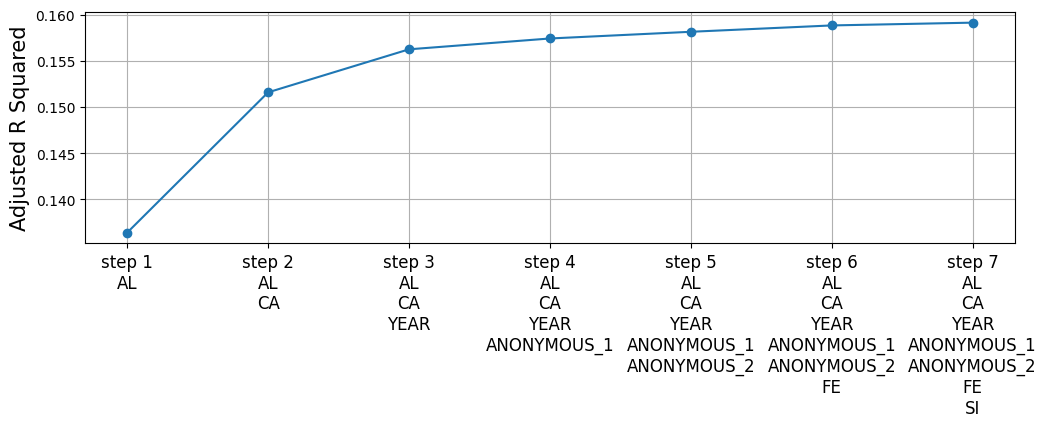

In [ ]:
fig = plt.figure(figsize=(12,3))
fig.set_facecolor('white')

font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')

plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [ ]:
train_X[selected_variables].corr()

,AL,CA,YEAR,ANONYMOUS_1,ANONYMOUS_2,FE,SI
AL,1.000000,-0.067434,-0.011515,0.012442,-0.028149,0.077638,0.118463
CA,-0.067434,1.000000,0.101730,-0.013581,-0.046242,-0.020017,-0.010113
YEAR,-0.011515,0.101730,1.000000,0.102155,0.137737,-0.066256,0.005691
ANONYMOUS_1,0.012442,-0.013581,0.102155,1.000000,0.077323,-0.004642,-0.006486
ANONYMOUS_2,-0.028149,-0.046242,0.137737,0.077323,1.000000,-0.001871,0.011623
FE,0.077638,-0.020017,-0.066256,-0.004642,-0.001871,1.000000,0.640990
SI,0.118463,-0.010113,0.005691,-0.006486,0.011623,0.640990,1.000000


`AL`, `CA`, `YEAR`, `ANONYMOUS_1`, `ANONYMOUS_2`, `FE`, `SI`, `PPM` 총 7개의 변수를 모델링에 사용

#### 1) CustomDataset

데이터셋을 적절한 형태로 변환

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation

    def __len__(self):
        return len(self.data_X)

    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            # teacher_X = torch.Tensor(self.data_X.iloc[index])
            teacher_X = torch.Tensor(self.data_X[['AL', 'CA', 'YEAR', 'ANONYMOUS_1', 'ANONYMOUS_2', 'FE', 'SI']].iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                # teacher_X = torch.Tensor(self.data_X.iloc[index])
                teacher_X = torch.Tensor(self.data_X[['AL', 'CA', 'YEAR', 'ANONYMOUS_1', 'ANONYMOUS_2', 'FE', 'SI']].iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [ ]:
train_dataset = CustomDataset(train_X,train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

#### 2) Teacher Model

##### Define Teacher Model


In [ ]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=7, out_features=256), #7,128
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=64), #128,64
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1), #64,1
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.classifier(x)
        return output


##### Teacher Train / Validation


In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []

        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)

            optimizer.zero_grad()

            y_pred = model(X)

            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)

        if best_score < val_score:
            best_model = model
            best_score = val_score

    return best_model

In [ ]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.2 #0.35

    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)

            model_pred = model(X.to(device))

            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())

            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()

        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1

##### Run (Teacher Model)


In [ ]:
# 80-81 기준,
model = Teacher()
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)#CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=1, threshold_mode='rel',min_lr=1e-8, verbose=True)# factor=0.5, abs

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.30522] Val Loss : [0.28099] Val F1 Score : [0.56293]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.24780] Val Loss : [0.26298] Val F1 Score : [0.67552]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22466] Val Loss : [0.23049] Val F1 Score : [0.74188]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.21118] Val Loss : [0.25928] Val F1 Score : [0.74574]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.21504] Val Loss : [0.55089] Val F1 Score : [0.28140]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.22307] Val Loss : [0.20753] Val F1 Score : [0.75466]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.19453] Val Loss : [0.20273] Val F1 Score : [0.78574]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.19868] Val Loss : [0.28132] Val F1 Score : [0.55553]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.20128] Val Loss : [0.19646] Val F1 Score : [0.76851]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.19432] Val Loss : [0.19484] Val F1 Score : [0.76044]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.20572] Val Loss : [0.25751] Val F1 Score : [0.60671]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.18593] Val Loss : [0.18129] Val F1 Score : [0.74413]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.18389] Val Loss : [0.23124] Val F1 Score : [0.64168]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.17680] Val Loss : [0.20732] Val F1 Score : [0.79007]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.18291] Val Loss : [0.41676] Val F1 Score : [0.45707]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.17584] Val Loss : [0.17846] Val F1 Score : [0.79491]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.17187] Val Loss : [0.17791] Val F1 Score : [0.73294]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.17440] Val Loss : [0.21312] Val F1 Score : [0.64800]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.17484] Val Loss : [0.26967] Val F1 Score : [0.77153]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.17253] Val Loss : [0.17790] Val F1 Score : [0.73130]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.16742] Val Loss : [0.18307] Val F1 Score : [0.76404]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.16763] Val Loss : [0.16526] Val F1 Score : [0.80788]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.17108] Val Loss : [0.16511] Val F1 Score : [0.79718]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.16483] Val Loss : [0.17246] Val F1 Score : [0.75874]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.16764] Val Loss : [0.16318] Val F1 Score : [0.80108]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.16569] Val Loss : [0.17319] Val F1 Score : [0.71872]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.16723] Val Loss : [0.16337] Val F1 Score : [0.79694]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.16619] Val Loss : [0.16446] Val F1 Score : [0.78678]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.16427] Val Loss : [0.16586] Val F1 Score : [0.77948]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.16667] Val Loss : [0.16794] Val F1 Score : [0.75071]


#### 3) Student Model

##### Define Student Model


In [ ]:
# (18,128), (128,512), (512,128), (128,1)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18, out_features=128), #18,64
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256), # 64,,256
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128), # 256,128
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=64), # 128,64
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=64), # 128,64
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1), #64,1
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.classifier(x)
        return output


##### Define Knowledge distillation Loss


In [ ]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [ ]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

##### Student Train / Validation


In [ ]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)

    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()

        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)

            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)

            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)

        if best_score < val_score:
            best_model = s_model
            best_score = val_score

    return best_model

In [ ]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35

    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)

            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)

            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)

            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()

        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1

##### Run (Student Model)


In [ ]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
# 기준 :  51
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.34667] Val Loss : [0.32150] Val F1 Score : [0.47771]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.31330] Val Loss : [0.31538] Val F1 Score : [0.47771]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.31276] Val Loss : [0.31508] Val F1 Score : [0.47771]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.31068] Val Loss : [0.31385] Val F1 Score : [0.47771]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.30962] Val Loss : [0.31219] Val F1 Score : [0.47771]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.30792] Val Loss : [0.31164] Val F1 Score : [0.47771]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.30713] Val Loss : [0.31206] Val F1 Score : [0.50881]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.30640] Val Loss : [0.31010] Val F1 Score : [0.50430]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.30532] Val Loss : [0.30869] Val F1 Score : [0.51315]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.30516] Val Loss : [0.31312] Val F1 Score : [0.51897]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.30313] Val Loss : [0.30746] Val F1 Score : [0.50823]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.30178] Val Loss : [0.30843] Val F1 Score : [0.49006]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.30248] Val Loss : [0.30562] Val F1 Score : [0.50842]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.29953] Val Loss : [0.30784] Val F1 Score : [0.48759]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.29913] Val Loss : [0.30405] Val F1 Score : [0.52305]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.29921] Val Loss : [0.30448] Val F1 Score : [0.51423]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.29872] Val Loss : [0.30429] Val F1 Score : [0.51700]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.29874] Val Loss : [0.30380] Val F1 Score : [0.52252]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.29781] Val Loss : [0.30353] Val F1 Score : [0.52452]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.29827] Val Loss : [0.30375] Val F1 Score : [0.52937]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.29890] Val Loss : [0.30313] Val F1 Score : [0.52561]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.29742] Val Loss : [0.30371] Val F1 Score : [0.52956]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.29718] Val Loss : [0.30360] Val F1 Score : [0.52323]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.29841] Val Loss : [0.30302] Val F1 Score : [0.52937]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.29712] Val Loss : [0.30305] Val F1 Score : [0.52704]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.29691] Val Loss : [0.30302] Val F1 Score : [0.52843]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.29734] Val Loss : [0.30315] Val F1 Score : [0.53130]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.29621] Val Loss : [0.30302] Val F1 Score : [0.53111]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.29708] Val Loss : [0.30297] Val F1 Score : [0.52667]


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.29684] Val Loss : [0.30290] Val F1 Score : [0.53091]


##### Choose Inference Threshold


In [ ]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()

    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    # thresholds = [0.2]

    pred_labels = []
    true_labels = []

    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)

            model_pred = model(x_s)

            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()

        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [ ]:
 # 기본모델 : Best Threshold : [0.2], Score : [0.56438]
# 층 두개 추가 (64,128~) : Best Threshold : [0.2], Score : [0.56618] <- PICK
# 층 두개 추가 한개 아웃 : Best Threshold : [0.1], Score : [0.54287]
# 층 두개 추가 학생모델 은닉노드 ;수 64~128로 조정 : Best Threshold : [0.1], Score : [0.55128]
# 층 두개 추가 층 하나 추가 (64~) : Best Threshold : [0.1], Score : [0.55098]
# 0.6 : Best Threshold : [0.2], Score : [0.54617]
# 변수 7개 사용 (층 두개 추가, 0.6): Best Threshold : [0.2], Score : [0.56016]
# 변수 7개 사용 (층 두가 추가, 0.5기본으로) : Best Threshold : [0.2], Score : [0.53837]
# 변수 7개 사용 (층 두개 추가, 0.7) : Best Threshold : [0.2], Score : [0.53661]
# 변수 7개 층 두개 추가에 한개 더 추가 (0.6) : Best Threshold : [0.25], Score : [0.55464]
# 변수 7개 층 두개만 추가 (32 없음) : Best Threshold : [0.2], Score : [0.53921]
# 변수 7개 층 세개 (32 추가) : Best Threshold : [0.2], Score : [0.57139]
# 7,128/128,64/64,64/64,1 //// 18,64/64,256/256,128/128,64/64,1 : Best Threshold : [0.2], Score : [0.56837]
# 위와 같음/일부 64=>128 : Best Threshold : [0.2], Score : [0.53717]
# 위와같음/ 모든 128->64 : Best Threshold : [0.2], Score : [0.53552]
# /층 하나 더 만듦(64,64) : Best Threshold : [0.2], Score : [0.53034]
# 128->256 첫 층 바꿈 / 위와같음: Best Threshold : [0.2], Score : [0.57721] => 0.564 (private)
# 2번째층 64->128 / 위와같음 : Best Threshold : [0.2], Score : [0.56199]
# 1번째층 256->400 / : Best Threshold : [0.1], Score : [0.54645]
# / 층 두개 삭제 : Best Threshold : [0.2], Score : [0.54632]
# /층두개삭제 수정 : Best Threshold : [0.2], Score : [0.55600] , Best Threshold : [0.2], Score : [0.56879]
# /층두개삭제 128->64,256->128 : Best Threshold : [0.2], Score : [0.56603]
# /층두개삭제(마지막 모델 STUDENT) : Best Threshold : [0.2], Score : [0.57361]
# SI 삭제 : Best Threshold : [0.2], Score : [0.56617]

# Best Threshold : [0.2], Score : [0.56424] (seed = 0)
# seed = 41 :
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/17 [00:00<?, ?it/s]

Best Threshold : [0.2], Score : [0.57721]


#### 4) Predict

##### Inference


In [ ]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()

    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred

    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [ ]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


### 5. Submit


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/건설기계 오일 상태 분류 경진대회/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [ ]:
len(submit[submit['Y_LABEL']==1])/len(submit)

0.050488329746730676

In [ ]:
submit.to_csv('./random_seed=0.csv', index=False)